In [1]:
import cv2
import numpy as np
import os
import glob
import pathlib
import shutil
import csv
from skimage.feature import hog
from sklearn.model_selection import train_test_split

In [2]:
try:
    os.remove('train_img_features_non_processed.npy')
    os.remove('test_img_features_non_processed.npy')
    os.remove('train_img_features_processed.npy')
    os.remove('test_img_features_processed.npy')
except:
    pass
try:
    shutil.rmtree('csvs')
    shutil.rmtree('csvs_processed')
except:
    pass

## Creacion de datos sin preprocesamiento

In [3]:
ruta = 'Dataset_traffic_sign/'
vectorClases = os.listdir(ruta)
nClases = len(vectorClases)
tam = 100
for clase,carpeta in enumerate(vectorClases):
    l = []
    rutaImagenes = ruta+carpeta
    vectorImagenes = os.listdir(rutaImagenes)
    nImagenes = len(vectorImagenes)
    for j in vectorImagenes:
        #Leemos imagen y aplicamos HOG
        #Leemos una imagen en blanco y negro
        rutaImg = rutaImagenes+'/'+j
        img = cv2.imread(rutaImg,0)
        img = cv2.resize(img,(tam,tam))
        #Extraemos las caracteristicas con hog
        hog_img = hog(img)
        l.append(hog_img)
        
    #Añadir la columna de la clase
    datos = np.array(l)
    y = np.full((nImagenes,1),clase)
    datos = np.hstack((datos,y))
    #Creamos csv de la clase
    rutaCsv = 'csvs/datos'+str(clase)+'.csv'
    pathlib.Path('csvs/').mkdir(parents=True, exist_ok=True) 
    with open(rutaCsv, 'a+', newline='') as myfile:
        wr = csv.writer(myfile)
        wr.writerows(datos)
        myfile.close()
        
n_features = datos.shape[1]

print('El numero de caracteristicas es {}\n'.format(n_features))

ruta = 'csvs/'
l_train = np.empty((0, n_features))
l_test = np.empty((0, n_features))

for i,csv_string in enumerate(sorted(os.listdir(ruta),key = lambda x: int(x.split('.')[0][len('datos'):]))):
    print("Creating train and test sets for {}".format(csv_string))
    rutaCsv = ruta+csv_string
    #Leemos los datos del csv_i y los guardamos en data
    data = np.loadtxt(rutaCsv,delimiter=',')
    X= data[:,:-1]
    y= data[:,-1].reshape(-1,1)
    
    #Creamos train y test con sklearn
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=2020)
    
    train = np.hstack((Xtrain,ytrain))
    test = np.hstack((Xtest,ytest))
    print("Total samples {}\ntrain samples {}\ntest samples {}\n".format(data.shape[0],train.shape[0],test.shape[0]))
    l_train = np.append(l_train,train).reshape(-1,n_features)
    l_test = np.append(l_test,test).reshape(-1,n_features)

print(l_train.shape)
print(l_test.shape)
np.save('train_img_features_non_processed',l_train)
np.save('test_img_features_non_processed',l_test)

El numero de caracteristicas es 8101

Creating train and test sets for datos0.csv
Total samples 6
train samples 4
test samples 2

Creating train and test sets for datos1.csv
Total samples 73
train samples 51
test samples 22

Creating train and test sets for datos2.csv
Total samples 74
train samples 51
test samples 23

Creating train and test sets for datos3.csv
Total samples 46
train samples 32
test samples 14

Creating train and test sets for datos4.csv
Total samples 65
train samples 45
test samples 20

Creating train and test sets for datos5.csv
Total samples 61
train samples 42
test samples 19

Creating train and test sets for datos6.csv
Total samples 13
train samples 9
test samples 4

Creating train and test sets for datos7.csv
Total samples 47
train samples 32
test samples 15

Creating train and test sets for datos8.csv
Total samples 46
train samples 32
test samples 14

Creating train and test sets for datos9.csv
Total samples 48
train samples 33
test samples 15

Creating train an

## Creacion de datos con preprocesamiento

Para mejorar el clasificador vamos procesar las imagenes para reducir ruido y darles un formato, es decir, un tamaño concreto rango de colores etc.

Podriamos agrupar la creacion de todos los datos en una sola celda pero lo hemos dejado asi para mostrar el proceso que hemos seguido. 

- Aumento del contraste
- Aumento de rango dinamico
- Ecualizacion del histograma
- Ajustar aspect ratio

In [4]:
ruta = 'Dataset_traffic_sign/'
vectorClases = os.listdir(ruta)
nClases = len(vectorClases)
tam = 100
for clase,carpeta in enumerate(vectorClases):
    l = []
    rutaImagenes = ruta+carpeta
    vectorImagenes = os.listdir(rutaImagenes)
    nImagenes = len(vectorImagenes)
    for j in vectorImagenes:
        #Leemos una imagen en blanco y negro
        rutaImg = rutaImagenes+'/'+j
        img = cv2.imread(rutaImg,0)
        img = cv2.resize(img,(tam,tam))
        #Procesamos la imagen
        
        #Ecualizacion de histograma
        img = cv2.equalizeHist(img)
        #Filtro
        kernel = np.ones((5,5),np.float32)/25
#         img = cv2.blur(img,(5,5))
        #Extraemos las caracteristicas con hog
        hog_img = hog(img)
        l.append(hog_img)
        
    #Añadir la columna de la clase
    datos = np.array(l)
    y = np.full((nImagenes,1),clase)
    datos = np.hstack((datos,y))
    #Creamos csv de la clase
    rutaCsv = 'csvs_processed/datos'+str(clase)+'.csv'
    pathlib.Path('csvs_processed/').mkdir(parents=True, exist_ok=True) 
    with open(rutaCsv, 'w+', newline='') as myfile:
        wr = csv.writer(myfile)
        wr.writerows(datos)
        myfile.close()
        
n_features = datos.shape[1]

print('El numero de caracteristicas es {}\n'.format(n_features))

ruta = 'csvs_processed/'
l_train = np.empty((0, n_features))
l_test = np.empty((0, n_features))

for i,csv_string in enumerate(sorted(os.listdir(ruta),key = lambda x: int(x.split('.')[0][len('datos'):]))):
    print("Creating train and test sets for {}".format(csv_string))
    rutaCsv = ruta+csv_string
    #Leemos los datos del csv_i y los guardamos en data
    data = np.loadtxt(rutaCsv,delimiter=',')
    X= data[:,:-1]
    y= data[:,-1].reshape(-1,1)
    
    #Creamos train y test con sklearn
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=2020)
    
    train = np.hstack((Xtrain,ytrain))
    test = np.hstack((Xtest,ytest))
    print("Total samples {}\ntrain samples {}\ntest samples {}\n".format(data.shape[0],train.shape[0],test.shape[0]))
    l_train = np.append(l_train,train).reshape(-1,n_features)
    l_test = np.append(l_test,test).reshape(-1,n_features)
    
print(l_train.shape)
print(l_test.shape)
np.save('train_img_features_processed',l_train)
np.save('test_img_features_processed',l_test)

El numero de caracteristicas es 8101

Creating train and test sets for datos0.csv
Total samples 6
train samples 4
test samples 2

Creating train and test sets for datos1.csv
Total samples 73
train samples 51
test samples 22

Creating train and test sets for datos2.csv
Total samples 74
train samples 51
test samples 23

Creating train and test sets for datos3.csv
Total samples 46
train samples 32
test samples 14

Creating train and test sets for datos4.csv
Total samples 65
train samples 45
test samples 20

Creating train and test sets for datos5.csv
Total samples 61
train samples 42
test samples 19

Creating train and test sets for datos6.csv
Total samples 13
train samples 9
test samples 4

Creating train and test sets for datos7.csv
Total samples 47
train samples 32
test samples 15

Creating train and test sets for datos8.csv
Total samples 46
train samples 32
test samples 14

Creating train and test sets for datos9.csv
Total samples 48
train samples 33
test samples 15

Creating train an

### Probar un conjunto de clasificadores usando SKlearn

In [5]:
import numpy as np
import pandas as pd
from sklearn import metrics

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.base import clone
import time
import matplotlib.pyplot as plt

nombresDatasets = ['non_processed','processed']
datasets = {}

for nombre in nombresDatasets:
    pathTrain = 'train_img_features_'+nombre+'.npy'
    pathTest = 'test_img_features_'+nombre+'.npy'
    
    dataTrain = np.load(pathTrain)
    Xtrain = dataTrain[:,:-1]
    ytrain = dataTrain[:,-1]
    
    dataTest = np.load(pathTest)
    Xtest = dataTest[:,:-1]
    ytest = dataTest[:,-1]
    
    datasets[nombre] = (Xtrain,ytrain,Xtest,ytest)

#Definimos un conjunto de clasificadores
classifiers = [
    SVC(),
    LogisticRegression(random_state=0,max_iter=400),
    GaussianNB(),
    DecisionTreeClassifier(),
    MLPClassifier()]

clf_names = ['SVM', 'Regr Logistica', 'NB Gaussiano','Decision Tree','Red Neuronal']

score_list = []
time_list = []
aux_params = []
Best_score = np.NINF

#Definimos un diccionario con diccionarios para los parametergrids de GridSearchCV
parameters_dict = {'SVM':{'kernel':('linear', 'rbf'), 'C':[1, 10],'gamma':[0.1,0.001]},
                    'Regr Logistica':{'C': [0.01, 1, 10, 1000] },
                    'NB Gaussiano':{'var_smoothing': np.logspace(0,-9, num=10)},
                    'Decision Tree':{'min_samples_split': [2, 3, 4],
                                     'criterion': ['gini', 'entropy']},
                    'Red Neuronal':{'activation': ['tanh', 'relu'],
                                    'solver': ['sgd', 'adam']}
                  }
#Probamos los clasificadores
for i,(clf_aux,clf_name) in enumerate(zip(classifiers,clf_names)):
    for j,dataset in enumerate(nombresDatasets):
        #Clonamos el clasificador ya que lo vamos a usar 2 veces
        clf = clone(clf_aux)
        
        #Extraemos los datos de train y test
        print('Entrenando {} con {}'.format(dataset,clf_name))
        (Xtrain,ytrain,Xtest,ytest) = datasets[dataset]
        
        #Calculamos los parametros optimos con GridSearchCV
        t0 = time.time()
        clf = GridSearchCV(clf,parameters_dict[clf_name],cv = 2,n_jobs=-1)
        clf.fit(Xtrain,ytrain)
        t1 = time.time()
        time_list.append(round(t1-t0),2)
        
        #Calculamos la precision, la guardamos y vemos si hemos mejorado
        score = round(clf.score(Xtest,ytest)*100,2)
        score_list.append(score)
        aux_params.append(clf.best_params_)
        if score >= Best_score:
            Best_score = score
            Best_dataset = dataset
            Best_clf = clf
            nBest_clf = i*2 +j
        print('Time elapsed on fit: {}\n'.format(round(t1-t0,2)))
print('Total time elapsed {}'.format(round(np.sum(time_list),2)))

Entrenando non_processed con SVM
Time elapsed on fit: 35.92

Entrenando processed con SVM
Time elapsed on fit: 35.46

Entrenando non_processed con Regr Logistica
Time elapsed on fit: 51.42

Entrenando processed con Regr Logistica
Time elapsed on fit: 50.72

Entrenando non_processed con NB Gaussiano
Time elapsed on fit: 15.88

Entrenando processed con NB Gaussiano
Time elapsed on fit: 15.7

Entrenando non_processed con Decision Tree
Time elapsed on fit: 21.22

Entrenando processed con Decision Tree
Time elapsed on fit: 33.77

Entrenando non_processed con Red Neuronal
Time elapsed on fit: 89.29

Entrenando processed con Red Neuronal
Time elapsed on fit: 91.93

Total time elapsed 441.29


## Funcion para mostrar resultados de score y tiempo

In [41]:
def graficas_resultados(bar_list,width = 0.35,title = None,best = None):
    '''Muestra graficas de resultados'''
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
        
    x = np.arange(len(clf_names))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize = (10,7))
    rects1 = ax.bar(x - width/2, bar_list[::2], width, label='no procesado',edgecolor='k')
    rects2 = ax.bar(x + width/2, bar_list[1::2], width, label='procesado',edgecolor='k')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title('Resultados clasificadores')
    ax.set_xticks(x)
    ax.set_xticklabels(clf_names)

    autolabel(rects1)
    autolabel(rects2)
    # print(score_list)
    # print(nBest_clf)
    i_clf = int(nBest_clf/2)
    if nBest_clf % 2 == 0:
        rects1[i_clf].set_color('r')
        rects1[i_clf].set_edgecolor('k')
    else:
        if score_list[i_clf] == score_list[i_clf-1]:
            rects1[i_clf].set_color('r')
            rects2[i_clf].set_color('r')
            rects1[i_clf].set_edgecolor('k')
            rects2[i_clf].set_edgecolor('k')
        else:
            rects2[i_clf].set_color('r')
            rects2[i_clf].set_edgecolor('k')
    fig.tight_layout()
    ax.legend(['No procesado','Procesado','Mejor'],loc=(0.62,0.9))

    plt.show()

    print('El mejor clasificador ha sido: {} en {}'.format(clf_names[i_clf],Best_dataset))
    print('La mejor puntuacion ha sido {} en {}'.format(Best_score,clf_names[i_clf]))

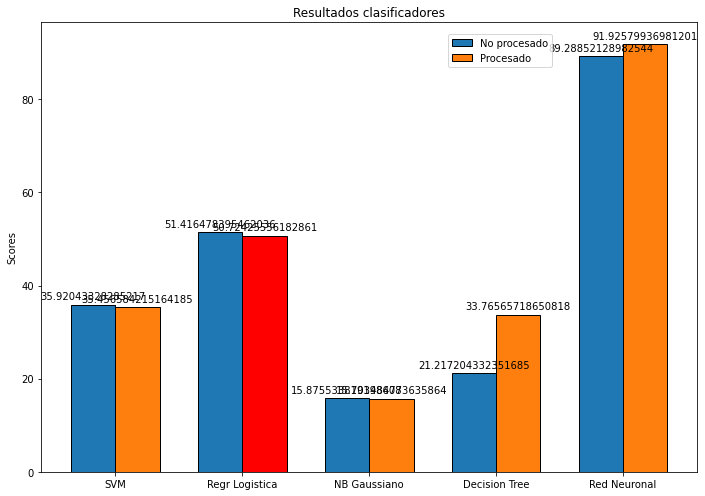

El mejor clasificador ha sido: Regr Logistica en processed
La mejor puntuacion ha sido 94.22 en Regr Logistica


In [39]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
x = np.arange(len(clf_names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (10,7))
rects1 = ax.bar(x - width/2, time_list[::2], width, label='no procesado',edgecolor='k')
rects2 = ax.bar(x + width/2, time_list[1::2], width, label='procesado',edgecolor='k')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Resultados clasificadores')
ax.set_xticks(x)
ax.set_xticklabels(clf_names)

autolabel(rects1)
autolabel(rects2)
# print(score_list)
# print(nBest_clf)
i_clf = int(nBest_clf/2)
if nBest_clf % 2 == 0:
    rects1[i_clf].set_color('r')
    rects1[i_clf].set_edgecolor('k')
else:
    if score_list[i_clf] == score_list[i_clf-1]:
        rects1[i_clf].set_color('r')
        rects2[i_clf].set_color('r')
        rects1[i_clf].set_edgecolor('k')
        rects2[i_clf].set_edgecolor('k')
    else:
        rects2[i_clf].set_color('r')
        rects2[i_clf].set_edgecolor('k')
fig.tight_layout()
ax.legend(['No procesado','Procesado'],loc=(0.62,0.9))

plt.show()

print('El mejor clasificador ha sido: {} en {}'.format(clf_names[i_clf],Best_dataset))
print('La mejor puntuacion ha sido {} en {}'.format(Best_score,clf_names[i_clf]))

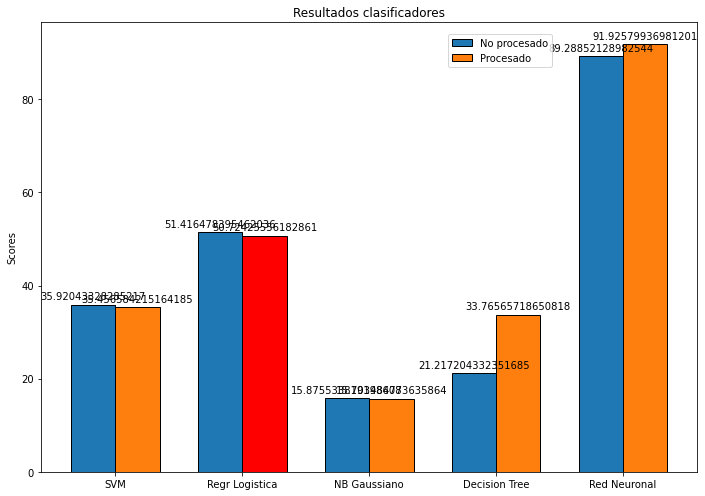

El mejor clasificador ha sido: Regr Logistica en processed
La mejor puntuacion ha sido 94.22 en Regr Logistica


In [43]:
#Graficas score
#Llamada funcion
graficas_resultados(time_list)

In [7]:
#Graficas de tiempo
#Llamada funcion

In [8]:
#Guardamos el mejor clasificador en disco para utilizarlo mas adelante

import pickle
# save the classifier
with open('sign_classifier.pkl', 'wb') as f:
    pickle.dump(Best_clf, f)  

## Deteccion de señales

Ahora a partir de las imagenes en Dataset_images/ vamos a crear un conjunto de imagenes tomando pequeñas imagenes 100x100 para entrenar un clasificador en este caso de tan solo 2 clases que nos permita averiguar si la imagen contiene o no una señal

Vamos a utilizar:

- 

In [ ]:
#Obtenemos las imagenes